<a href="https://colab.research.google.com/github/kauterry/seamless_communication/blob/main/Seamless_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quick Links

1. seamless_communication GitHub repository: https://github.com/facebookresearch/seamless_communication
2. fairseq2 Github repository: https://github.com/facebookresearch/fairseq2
3. HuggingFace: https://huggingface.co/collections/facebook/seamless-communication-6568d486ef451c6ba62c7724
4. Seamless demos: https://seamless.metademolab.com/
5. Fleurs datasets for evaluation: https://huggingface.co/datasets/google/fleurs/tree/main/data

### Set up seamless_communication, fairseq2 and some utilities.

In [ ]:
%%capture
# Makeshift for now, but generally `pip install fairseq2` should work.
!pip install fairseq2==0.2.1.dev202311301403+cu118 --pre --extra-index-url https://fair.pkg.atmeta.com/fairseq2/whl/nightly/pt2.1.1/cu118
!pip install pydub sentencepiece
!pip install git+https://github.com/facebookresearch/seamless_communication.git

In [ ]:
import io
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import mmap
import numpy
import soundfile
import torchaudio
import torch

from collections import defaultdict
from IPython.display import Audio, display
from pathlib import Path
from pydub import AudioSegment

from seamless_communication.inference import Translator
from seamless_communication.streaming.dataloaders.s2tt import SileroVADSilenceRemover

# SeamlessM4T Inference:

## Initialize the models:

In [ ]:
# Initialize a Translator object with a multitask model, vocoder on the GPU.

model_name = "seamlessM4T_v2_large"
vocoder_name = "vocoder_v2" if model_name == "seamlessM4T_v2_large" else "vocoder_36langs"

translator = Translator(
    model_name,
    vocoder_name,
    device=torch.device("cuda:0"),
    dtype=torch.float16,
)

100%|██████████| 8.45G/8.45G [05:42<00:00, 26.5MB/s]
100%|██████████| 360k/360k [00:00<00:00, 1.36MB/s]
100%|██████████| 4.93M/4.93M [00:00<00:00, 58.2MB/s]
Using the cached tokenizer of seamlessM4T_v2_large. Set `force` to `True` to download again.
100%|██████████| 160M/160M [00:01<00:00, 86.0MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
# Download an english audio sample from the LJ speech dataset for testing purposes.
%%capture
!wget https://dl.fbaipublicfiles.com/seamlessM4T/LJ037-0171_sr16k.wav -O /content/LJ_eng.wav

## S2ST inference:

In [ ]:
# README:  https://github.com/facebookresearch/seamless_communication/tree/main/src/seamless_communication/cli/m4t/predict
# Please use audios with duration under 20 seconds for optimal performance.

# Resample the audio in 16khz if sample rate is not 16khz already.
# torchaudio.functional.resample(audio, orig_freq=orig_freq, new_freq=16_000)

print("English audio:")
in_file = "/content/LJ_eng.wav"
display(Audio(in_file, rate=16000, autoplay=False, normalize=True))

tgt_langs = ("spa", "fra", "deu", "ita", "hin", "cmn")

for tgt_lang in tgt_langs:
  text_output, speech_output = translator.predict(
      input=in_file,
      task_str="s2st",
      tgt_lang=tgt_lang,
  )

  print(f"Translated text in {tgt_lang}: {text_output[0]}")
  print()

  out_file = f"/content/translated_LJ_{tgt_lang}.wav"

  torchaudio.save(out_file, speech_output.audio_wavs[0][0].to(torch.float32).cpu(), speech_output.sample_rate)

  print(f"Translated audio in {tgt_lang}:")
  audio_play = Audio(out_file, rate=speech_output.sample_rate, autoplay=False, normalize=True)
  display(audio_play)
  print()

## S2TT inference:

In [ ]:
tgt_langs = ("arb", "rus", "tgl", "ind", "tam", "kor")
in_file = "/content/LJ_eng.wav"

for tgt_lang in tgt_langs:

  text_output, _ = translator.predict(
      input=in_file,
      task_str="s2tt",
      tgt_lang=tgt_lang,
  )

  print(f"Translated text in {tgt_lang}: {text_output[0]}")
  print()

Translated text in arb: فحص وشهادة الخبراء مكنت اللجنة من الاستنتاج بأن خمس طلقات قد تم إطلاقها

Translated text in rus: Исследование и свидетельские показания экспертов позволили комиссии заключить, что пять выстрелов, возможно, были сделаны

Translated text in tgl: Ang pagsusuri at patotoo ng mga eksperto ay nagpahintulot sa komisyon na magtapos na limang pagbaril ang maaaring binaril.

Translated text in ind: pemeriksaan dan kesaksian para ahli memungkinkan komisi untuk menyimpulkan bahwa lima tembakan mungkin telah ditembakkan

Translated text in tam: நிபுணர்களின் பரிசோதனை மற்றும் சாட்சியம் ஐந்து துப்பாக்கிச் சூடுகள் நடத்தப்பட்டிருக்கலாம் என்று முடிவு செய்ய ஆணையத்திற்கு உதவியது.

Translated text in kor: 전문가들의 조사와 증언은 위원회가 5발의 총격이 발사됐을 수 있다는 결론을 내릴 수 있게 해 ⁇ 습니다.



## ASR inference:

In [ ]:
tgt_langs = ("spa", "fra", "deu", "ita", "hin", "cmn")

for tgt_lang in tgt_langs:
  in_file = f"/content/translated_LJ_{tgt_lang}.wav"

  text_output, _ = translator.predict(
      input=in_file,
      task_str="asr",
      tgt_lang=tgt_lang,
  )

  print(f"Transcribed text in {tgt_lang}: {text_output[0]}")
  print()

Transcribed text in spa: El examen y testimonio de los expertos permitieron a la comisión concluir que cinco disparos pueden haber sido disparados.

Transcribed text in fra: L'examen et le témoignage des experts ont permis à la commission de conclure que cinq coups de feu ont pu être tirés.

Transcribed text in deu: Die Prüfung und das Zeugnis der Experten ermöglichten es der Kommission, zu dem Schluss zu kommen, dass fünf Schüsse abgefeuert wurden.

Transcribed text in ita: L'esame e la testimonianza degli esperti hanno permesso alla commissione di concludere che cinque colpi possono essere stati sparati.

Transcribed text in hin: विशेषज्ञों की जांच और गवाही ने आयोग को यह निष्कर्ष निकालने में सक्षम बनाया कि पांच गोलीबारी की जा सकती है।

Transcribed text in cmn: 专家的检查和证词史委员会的出结论可能有五次枪击



## T2ST inference:

In [ ]:
tgt_langs = ("spa", "fra", "deu", "ita", "hin", "cmn")

for tgt_lang in tgt_langs:

  text_output, speech_output = translator.predict(
      input="Hey everyone! I hope you're all doing well. Thank you for attending our workshop.",
      task_str="t2st",
      tgt_lang=tgt_lang,
      src_lang="eng",
  )

  print(f"Translated text in {tgt_lang}: {text_output[0]}")
  print()

  out_file = f"/content/{tgt_lang}.wav"

  torchaudio.save(out_file, speech_output.audio_wavs[0][0].to(torch.float32).cpu(), speech_output.sample_rate)

  print(f"Translated audio in {tgt_lang}:")
  audio_play = Audio(out_file, rate=speech_output.sample_rate, autoplay=False, normalize=True)
  display(audio_play)
  print()

Translated text in spa: Hola a todos, espero que todos estéis bien, gracias por asistir a nuestro taller.

Translated audio in spa:



Translated text in fra: Bonjour à tous ! J'espère que vous allez bien. Merci d'avoir assisté à notre atelier.

Translated audio in fra:



Translated text in deu: Hallo alle! Ich hoffe, dass es euch allen gut geht. Danke, dass ihr an unserem Workshop teilgenommen habt.

Translated audio in deu:



Translated text in ita: Salve a tutti! Spero che stiate tutti bene. Grazie per aver partecipato al nostro workshop.

Translated audio in ita:



Translated text in hin: हैलो सभी! मुझे आशा है कि आप सभी अच्छा कर रहे हैं। हमारी कार्यशाला में भाग लेने के लिए धन्यवाद।

Translated audio in hin:



Translated text in cmn: 大家好!我希望你们都很好.谢谢你们参加我们的研讨会.

Translated audio in cmn:


## T2TT (MT) inference:

In [ ]:
tgt_langs = ("arb", "rus", "ind", "tam", "kor")

for tgt_lang in tgt_langs:

  text_output, speech_output = translator.predict(
      input="Hey everyone! I hope you're all doing well. Thank you for attending our workshop.",
      task_str="t2tt",
      tgt_lang=tgt_lang,
      src_lang="eng",
  )

  print(f"Translated text in {tgt_lang}: {text_output[0]}")
  print()


Translated text in arb: مرحباً للجميع! آمل أن تكونوا جميعاً بخير. شكراً لحضور ورشتنا.

Translated text in rus: Привет всем! Надеюсь, вы все в порядке. Спасибо, что присутствовали на нашем семинаре.

Translated text in ind: Hai semua orang! Saya harap kalian semua baik-baik saja. Terima kasih telah menghadiri lokakarya kami.

Translated text in tam: எல்லோருக்கும் வணக்கம், நீங்கள் அனைவரும் நன்றாக இருக்கிறீர்கள் என்று நம்புகிறேன், எங்கள் பட்டறையில் கலந்து கொண்டதற்கு நன்றி.

Translated text in kor: 안 ⁇ 하세요! 모두들 잘 지내셨으면 좋겠습니다. 워크 ⁇ 에 참석해 주셔서 감사합니다.



## UnitY2 aligner usage

In [ ]:
from seamless_communication.models.aligner.alignment_extractor import AlignmentExtractor
from fairseq2.typing import Device
import torch

In [ ]:
alignment_extractor = AlignmentExtractor(
    aligner_model_name_or_card="nar_t2u_aligner",
    unit_extractor_model_name_or_card="xlsr2_1b_v2",
    unit_extractor_output_layer=35,
    unit_extractor_kmeans_model_uri="https://dl.fbaipublicfiles.com/seamlessM4T/models/unit_extraction/kmeans_10k.npy",
)

Using the cached checkpoint of nar_t2u_aligner. Set `force` to `True` to download again.
Using the cached tokenizer of nar_t2u_aligner. Set `force` to `True` to download again.
Using the cached checkpoint of xlsr2_1b_v2. Set `force` to `True` to download again.
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Using the cached checkpoint of https://dl.fbaipublicfiles.com/seamlessM4T/models/unit_extraction/kmeans_10k.npy. Set `force` to `True` to download again.


In [ ]:
# downloading en audio
! wget https://dl.fbaipublicfiles.com/seamlessM4T/LJ037-0171_sr16k.wav

--2023-12-14 01:40:01--  https://dl.fbaipublicfiles.com/seamlessM4T/LJ037-0171_sr16k.wav
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 485430 (474K) [audio/x-wav]
Saving to: ‘LJ037-0171_sr16k.wav’

LJ037-0171_sr16k.wa 100%[===================>] 474.05K  --.-KB/s    in 0.04s   

2023-12-14 01:40:02 (10.8 MB/s) - ‘LJ037-0171_sr16k.wav’ saved [485430/485430]



In [ ]:
# listen to the audio
en_transcription = "the examination and testimony of the experts enabled the commision to conclude that five shots may have been fired."
audio_play = Audio("LJ037-0171_sr16k.wav", rate=16_000, autoplay=False, normalize=True)
display(audio_play)
print(en_transcription)

the examination and testimony of the experts enabled the commision to conclude that five shots may have been fired.


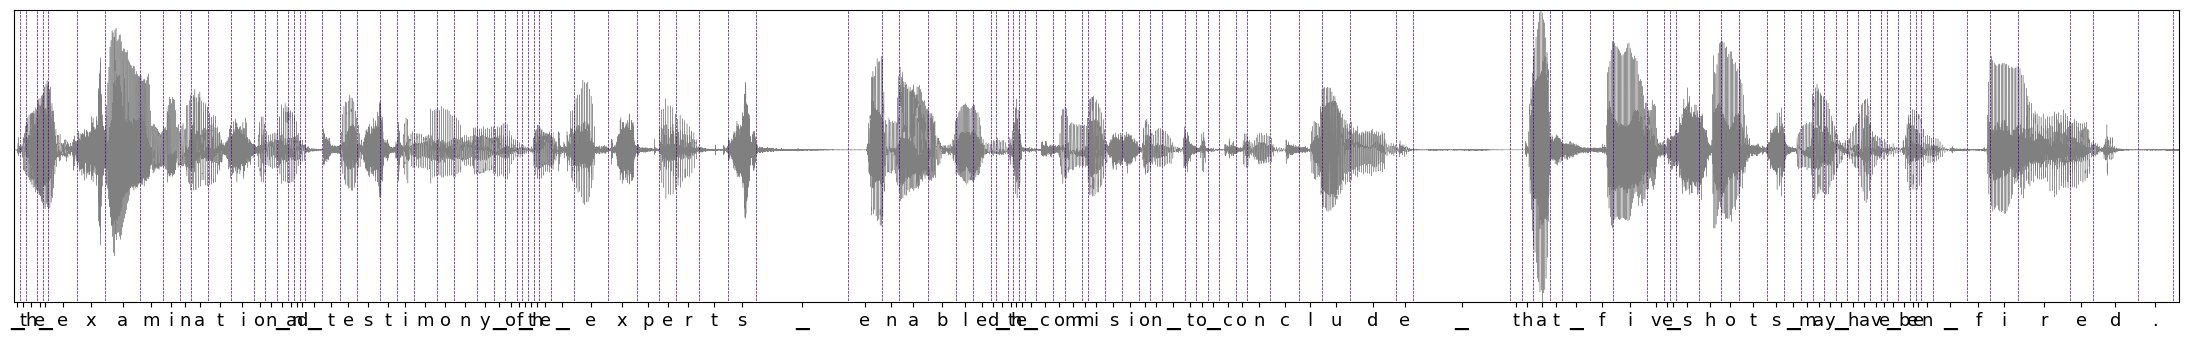

In [ ]:
alignment_durations, _, tokenized_text_tokens = alignment_extractor.extract_alignment("LJ037-0171_sr16k.wav", en_transcription, plot=True, add_trailing_silence=False)


## HF transformers:

In [ ]:
# Refer to README: https://github.com/facebookresearch/seamless_communication/tree/main/docs/m4t#transformers-usage
# HF space: https://huggingface.co/spaces/facebook/seamless-m4t-v2-large

## m4t_evaluate

In [ ]:
# Refer to README: https://github.com/facebookresearch/seamless_communication/tree/main/src/seamless_communication/cli/m4t/evaluate

# SeamlessExpressive Inference:

In [ ]:
# Please follow instructions to download SeamlessExpressive here: https://ai.meta.com/resources/models-and-libraries/seamless-downloads/

# !wget "<download_link_in_email>" -O /content/SeamlessExpressive.tar.gz
!wget "https://d11ywzt2xtszji.cloudfront.net/SeamlessExpressive.tar.gz?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiemRzazFpMG5ydWQ4MzMweG8xbmhzbnBoIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZDExeXd6dDJ4dHN6amkuY2xvdWRmcm9udC5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3MDI1MzMzNzJ9fX1dfQ__&Signature=OisIVzG0HU6YNMs3kQ0PwnjN%7ERtDuG-x09eMIEmqDwp1nqK4FbKMXgEV9qKzvCe9jZFqJmpIsi3vkdPFZUijUyvnx4gAW1VAMlbW-6MQKR9SHIS445f2lB7DwG%7EO%7EpVuysA63x7vunX1fIr2OBRjSWDZwrCmMcZ82d0oNVGSEmkV5uEzfnIIBxbgARs3fIdvMED0y%7EJdCHX6sxAvDk2bnVq1hyKF%7EmIXqpveLBFKx0eBXlNSDYYC1i5EZ1gnhWEf0koSh%7EQ-ruUVVNn2XzqYBthAwDXuaVVqRsosZkRMWB6S5c0aokP4PQjr1ReSBjUizy0NSzAvtKZhbJz5W4JRjw__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=3569896919899546" -O /content/SeamlessExpressive.tar.gz

!tar -xzvf /content/SeamlessExpressive.tar.gz

--2023-12-13 13:02:00--  https://d11ywzt2xtszji.cloudfront.net/SeamlessExpressive.tar.gz?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiemRzazFpMG5ydWQ4MzMweG8xbmhzbnBoIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZDExeXd6dDJ4dHN6amkuY2xvdWRmcm9udC5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3MDI1MzMzNzJ9fX1dfQ__&Signature=OisIVzG0HU6YNMs3kQ0PwnjN%7ERtDuG-x09eMIEmqDwp1nqK4FbKMXgEV9qKzvCe9jZFqJmpIsi3vkdPFZUijUyvnx4gAW1VAMlbW-6MQKR9SHIS445f2lB7DwG%7EO%7EpVuysA63x7vunX1fIr2OBRjSWDZwrCmMcZ82d0oNVGSEmkV5uEzfnIIBxbgARs3fIdvMED0y%7EJdCHX6sxAvDk2bnVq1hyKF%7EmIXqpveLBFKx0eBXlNSDYYC1i5EZ1gnhWEf0koSh%7EQ-ruUVVNn2XzqYBthAwDXuaVVqRsosZkRMWB6S5c0aokP4PQjr1ReSBjUizy0NSzAvtKZhbJz5W4JRjw__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=3569896919899546
Resolving d11ywzt2xtszji.cloudfront.net (d11ywzt2xtszji.cloudfront.net)... 13.224.14.34, 13.224.14.101, 13.224.14.23, ...
Connecting to d11ywzt2xtszji.cloudfront.net (d11ywzt2xtszji.cloudfront.net)|13.224.14.34|:443... connected.
HTTP reque

In [ ]:
!wget https://dl.fbaipublicfiles.com/seamless/data/samples/expressivity_data.tar.gz -O /content/expressivity_data.tar.gz
!tar -xzvf /content/expressivity_data.tar.gz

--2023-12-10 21:57:06--  https://dl.fbaipublicfiles.com/seamless/data/samples/expressivity_data.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.38, 13.35.7.50, 13.35.7.82, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571233 (558K) [application/x-tar]
Saving to: ‘/content/expressivity_data.tar.gz’

/content/expressivi 100%[===================>] 557.84K  1.43MB/s    in 0.4s    

2023-12-10 21:57:07 (1.43 MB/s) - ‘/content/expressivity_data.tar.gz’ saved [571233/571233]

./
./ex01_whisper_00367.wav
./ex01_confused_00367.wav
./ex01_enunciated_00367.wav
./ex01_happy_00367.wav
./ex01_sad_00367.wav
./ex01_laughing_00367.wav
./ex01_default_00367.wav


In [ ]:
expressions = ("default", "whisper", "confused", "enunciated", "happy", "sad", "laughing")

for expression in expressions:
  print(f"English {expression} audio:")
  print()

  in_file = f"ex01_{expression}_00367.wav"

  audio_play = Audio(in_file, rate=16000, autoplay=False, normalize=True)
  display(audio_play)

  out_file = f"spa_{expression}.wav"

  !expressivity_predict {in_file} --tgt_lang spa \
    --model_name seamless_expressivity --vocoder_name vocoder_pretssel \
    --gated-model-dir SeamlessExpressive --output_path {out_file}

  print()
  print(f"Translated {expression} audio in spa:")

  audio_play = Audio(out_file, rate=16000, autoplay=False, normalize=True)
  display(audio_play)

## Automatic Expressive Evaluation:

In [ ]:
# Refer to README: https://github.com/facebookresearch/seamless_communication/blob/main/docs/expressive/README.md#automatic-evaluation

# AutoPCP: https://github.com/facebookresearch/stopes/tree/main/stopes/eval/auto_pcp

# VSim: https://github.com/facebookresearch/stopes/tree/main/stopes/eval/vocal_style_similarity

# expressivity_evaluate: https://github.com/facebookresearch/seamless_communication#seamlessexpressive-evaluation

# HF space: https://huggingface.co/spaces/facebook/seamless-expressive

# Streaming Standalone Inference



## Utility classes + functions

In [ ]:
# Download an the LJ speech dataset sample if you didn't already run it above
# %%capture
!wget https://dl.fbaipublicfiles.com/seamlessM4T/LJ037-0171_sr16k.wav -O /content/LJ_eng.wav

--2023-12-13 06:11:00--  https://dl.fbaipublicfiles.com/seamlessM4T/LJ037-0171_sr16k.wav
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.108, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 485430 (474K) [audio/x-wav]
Saving to: ‘/content/LJ_eng.wav’

/content/LJ_eng.wav 100%[===================>] 474.05K  --.-KB/s    in 0.04s   

2023-12-13 06:11:00 (13.0 MB/s) - ‘/content/LJ_eng.wav’ saved [485430/485430]



In [ ]:
import math
from simuleval.data.segments import SpeechSegment, EmptySegment
from seamless_communication.streaming.agents.seamless_streaming_s2st import (
    SeamlessStreamingS2STVADAgent,
)

from simuleval.utils.arguments import cli_argument_list
from simuleval import options


from typing import Union, List
from simuleval.data.segments import Segment, TextSegment
from simuleval.agents.pipeline import TreeAgentPipeline
from simuleval.agents.states import AgentStates


SAMPLE_RATE = 16000


class AudioFrontEnd:
    def __init__(self, wav_file, segment_size) -> None:
        self.samples, self.sample_rate = soundfile.read(wav_file)
        assert self.sample_rate == SAMPLE_RATE
        # print(len(self.samples), self.samples[:100])
        self.samples = self.samples  # .tolist()
        self.segment_size = segment_size
        self.step = 0

    def send_segment(self):
        """
        This is the front-end logic in simuleval instance.py
        """

        num_samples = math.ceil(self.segment_size / 1000 * self.sample_rate)

        if self.step < len(self.samples):
            if self.step + num_samples >= len(self.samples):
                samples = self.samples[self.step :]
                is_finished = True
            else:
                samples = self.samples[self.step : self.step + num_samples]
                is_finished = False
            self.step = min(self.step + num_samples, len(self.samples))

            segment = SpeechSegment(
                content=samples,
                sample_rate=self.sample_rate,
                finished=is_finished,
            )
        else:
            # Finish reading this audio
            segment = EmptySegment(
                finished=True,
            )
        return segment


class OutputSegments:
    def __init__(self, segments: Union[List[Segment], Segment]):
        if isinstance(segments, Segment):
            segments = [segments]
        self.segments: List[Segment] = [s for s in segments]

    @property
    def is_empty(self):
        return all(segment.is_empty for segment in self.segments)

    @property
    def finished(self):
        return all(segment.finished for segment in self.segments)


def get_audiosegment(samples, sr):
    b = io.BytesIO()
    soundfile.write(b, samples, samplerate=sr, format="wav")
    b.seek(0)
    return AudioSegment.from_file(b)


def reset_states(system, states):
    if isinstance(system, TreeAgentPipeline):
        states_iter = states.values()
    else:
        states_iter = states
    for state in states_iter:
        state.reset()


def get_states_root(system, states) -> AgentStates:
    if isinstance(system, TreeAgentPipeline):
        # self.states is a dict
        return states[system.source_module]
    else:
        # self.states is a list
        return system.states[0]


def plot_s2st(source_file, target_samples, target_fs, intervals, delays, prediction_lists):
    mpl.rcParams["axes.spines.left"] = False
    mpl.rcParams["axes.spines.right"] = False
    mpl.rcParams["axes.spines.top"] = False
    mpl.rcParams["axes.spines.bottom"] = False

    source_samples, source_fs = soundfile.read(source_file)

    _, axes = plt.subplots(5, sharex=True, figsize=(25, 5))
    for ax in axes:
        ax.set_yticks([])

    axes[0].plot(
        numpy.linspace(0, len(source_samples) / source_fs, len(source_samples)),
        source_samples,
    )

    axes[1].plot(
        numpy.linspace(0, len(target_samples) / target_fs, len(target_samples)),
        target_samples,
    )

    start = 0
    for seg_index in range(len(intervals)):
        start, duration = intervals[seg_index]
        offset = delays["s2st"][seg_index]

        samples = target_samples[
            int((start) / 1000 * target_fs) : int(
                (start + duration) / 1000 * target_fs
            )
        ]

        # Uncomment this if you want to see the segments without speech playback delay
        axes[2].plot(
            offset / 1000 + numpy.linspace(0, len(samples) / target_fs, len(samples)),
            -seg_index * 0.05 + numpy.array(samples),
        )
        axes[4].plot(
            start / 1000 + numpy.linspace(0, len(samples) / target_fs, len(samples)),
            numpy.array(samples),
        )

    from pydub import AudioSegment
    print("Output translation (without input)")
    display(Audio(target_samples, rate=target_fs))
    print("Output translation (overlay with input)")
    source_seg = get_audiosegment(source_samples, source_fs) + AudioSegment.silent(duration=3000)
    target_seg = get_audiosegment(target_samples, target_fs)
    output_seg = source_seg.overlay(target_seg)
    display(output_seg)

    delay_token = defaultdict(list)
    d = delays["s2tt"][0]
    for token, delay in zip(prediction_lists["s2tt"], delays["s2tt"]):
        if delay != d:
            d = delay
        delay_token[d].append(token)
    for key, value in delay_token.items():
        axes[3].text(
            key / 1000, 0.2, " ".join(value), rotation=40
        )

def build_streaming_system(model_configs, agent_class):
    parser = options.general_parser()
    parser.add_argument("-f", "--f", help="a dummy argument to fool ipython", default="1")

    agent_class.add_args(parser)
    args, _ = parser.parse_known_args(cli_argument_list(model_configs))
    system = agent_class.from_args(args)
    return system


def run_streaming_inference(system, audio_frontend, system_states, tgt_lang):
    # NOTE: Here for visualization, we calculate delays offset from audio
    # *BEFORE* VAD segmentation.
    # In contrast for SimulEval evaluation, we assume audios are pre-segmented,
    # and Average Lagging, End Offset metrics are based on those pre-segmented audios.
    # Thus, delays here are *NOT* comparable to SimulEval per-segment delays
    delays = {"s2st": [], "s2tt": []}
    prediction_lists = {"s2st": [], "s2tt": []}
    speech_durations = []
    curr_delay = 0
    target_sample_rate = None

    while True:
        input_segment = audio_frontend.send_segment()
        input_segment.tgt_lang = tgt_lang
        curr_delay += len(input_segment.content) / SAMPLE_RATE * 1000
        if input_segment.finished:
            # a hack, we expect a real stream to end with silence
            get_states_root(system, system_states).source_finished = True
        # Translation happens here
        output_segments = OutputSegments(system.pushpop(input_segment, system_states))
        if not output_segments.is_empty:
            for segment in output_segments.segments:
                # NOTE: another difference from SimulEval evaluation -
                # delays are accumulated per-token
                if isinstance(segment, SpeechSegment):
                    pred_duration = 1000 * len(segment.content) / segment.sample_rate
                    speech_durations.append(pred_duration)
                    delays["s2st"].append(curr_delay)
                    prediction_lists["s2st"].append(segment.content)
                    target_sample_rate = segment.sample_rate
                elif isinstance(segment, TextSegment):
                    delays["s2tt"].append(curr_delay)
                    prediction_lists["s2tt"].append(segment.content)
                    print(curr_delay, segment.content)
        if output_segments.finished:
            print("End of VAD segment")
            reset_states(system, system_states)
        if input_segment.finished:
            # an assumption of SimulEval agents -
            # once source_finished=True, generate until output translation is finished
            assert output_segments.finished
            break
    return delays, prediction_lists, speech_durations, target_sample_rate


def get_s2st_delayed_targets(delays, target_sample_rate, prediction_lists, speech_durations):
    # get calculate intervals + durations for s2st
    intervals = []

    start = prev_end = prediction_offset = delays["s2st"][0]
    target_samples = [0.0] * int(target_sample_rate * prediction_offset / 1000)

    for i, delay in enumerate(delays["s2st"]):
        start = max(prev_end, delay)

        if start > prev_end:
            # Wait source speech, add discontinuity with silence
            target_samples += [0.0] * int(
                target_sample_rate * (start - prev_end) / 1000
            )

        target_samples += prediction_lists["s2st"][i]
        duration = speech_durations[i]
        prev_end = start + duration
        intervals.append([start, duration])
    return target_samples, intervals

## Build SeamlessStreaming S2ST + S2TT agent

In [ ]:
from seamless_communication.streaming.agents.seamless_streaming_s2st import (
    SeamlessStreamingS2STJointVADAgent,
)


print("building system from dir")

agent_class = SeamlessStreamingS2STJointVADAgent
tgt_lang = "spa"

model_configs = dict(
    source_segment_size=320,
    device="cuda:0",
    dtype="fp16",
    min_starting_wait_w2vbert=192,
    decision_threshold=0.5,
    min_unit_chunk_size=50,
    no_early_stop=True,
    max_len_a=0,
    max_len_b=100,
    task="s2st",
    tgt_lang=tgt_lang,
    block_ngrams=True,
    detokenize_only=True,
)
system = build_streaming_system(model_configs, agent_class)
print("finished building system")

building system from dir


100%|██████████| 4.93M/4.93M [00:00<00:00, 18.8MB/s]
100%|██████████| 3.34G/3.34G [00:29<00:00, 122MB/s]
100%|██████████| 360k/360k [00:00<00:00, 13.8MB/s]
Using the cached tokenizer of seamlessM4T_v2_large. Set `force` to `True` to download again.
100%|██████████| 3.98G/3.98G [00:35<00:00, 121MB/s]
/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-vad/

finished building system


## Initialize states + run inference

In [ ]:
source_segment_size = 320  # milliseconds
audio_frontend = AudioFrontEnd(
    wav_file="/content/LJ_eng.wav",
    segment_size=source_segment_size,
)

system_states = system.build_states()

# you can pass tgt_lang at inference time to change the output lang.
# SeamlessStreaming supports 36 speech output languages, see https://github.com/facebookresearch/seamless_communication/blob/main/docs/m4t/README.md#supported-languages
# in the Target column for `Sp` outputs.
delays, prediction_lists, speech_durations, target_sample_rate = run_streaming_inference(
    system, audio_frontend, system_states, tgt_lang
)


Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


3200.0 El examen y el testimonio de los expertos
4160.0 permitieron
4800.0 a la Comisión
5120.0 concluir
7040.0 que
7360.0 cinco disparos pudieron
7583.9375 haber sido disparados,
End of VAD segment


## Visualize streaming outputs

The top row is the input audio, while the later rows are the output audio (in chunks), as well as output text, offset by the corresponding delays.

Output translation (without input)


Output translation (overlay with input)


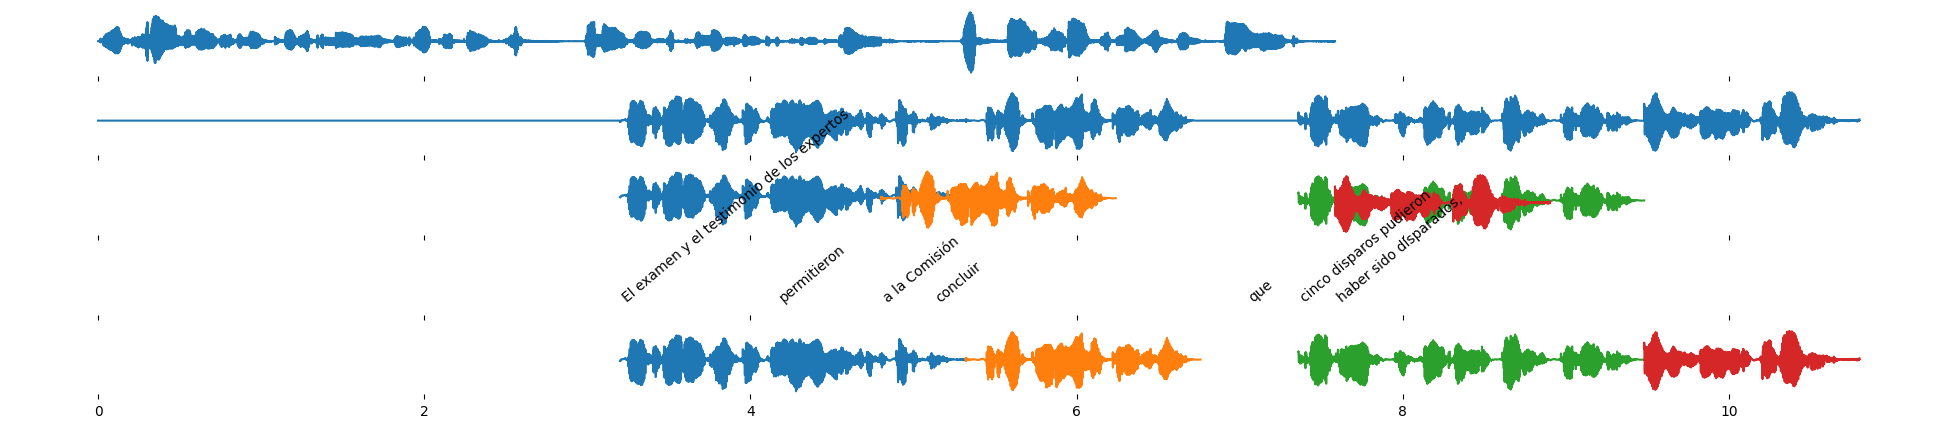

In [ ]:
target_samples, intervals = get_s2st_delayed_targets(delays, target_sample_rate, prediction_lists, speech_durations)

plot_s2st("/content/LJ_eng.wav", target_samples, target_sample_rate, intervals, delays, prediction_lists)

## Seamless Unified Inference

In [ ]:
# If you haven't already above, please follow instructions to download
# SeamlessExpressive here: https://ai.meta.com/resources/models-and-libraries/seamless-downloads/

!wget "https://d11ywzt2xtszji.cloudfront.net/SeamlessExpressive.tar.gz?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiZ2sxMzhuZnNkNDQ0dmM2dDhhazgxbWluIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZDExeXd6dDJ4dHN6amkuY2xvdWRmcm9udC5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3MDI1NzIxMjl9fX1dfQ__&Signature=npTULjeiKp9U8hUng4f9Njb6QKpK52Rl9pQjRpamsQSNzWgYeshMABRUNjWQJrw5givbbdGhaa6mW2l3UYHi66x3rBLazIS7d7npHu6aTElyNRZtFgjKMlNWSRfZOXh7NsQSZOFwWy0VxJwVZ%7EKtJnBWvgh7Mov3SKeJFeJEdAESDVO%7EWCHO1Z2zIWl%7EIkfpX5OnMqz7ntU9SpzsVpEHgefcyktm5NZ2xIr%7EoOml3YUXwNEUDj5PhLUkeoSHpFXHSzI0S0GHlxp48C162gUS8qK1HtaXalk7GUDem%7ErAGpx-Bo9oPBe33PdSsvpqngT9E32eS33oJoU1am4RGKFysg__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1024805765443779" -O /content/SeamlessExpressive.tar.gz
!tar -xzvf /content/SeamlessExpressive.tar.gz

--2023-12-13 21:45:45--  https://d11ywzt2xtszji.cloudfront.net/SeamlessExpressive.tar.gz?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiZ2sxMzhuZnNkNDQ0dmM2dDhhazgxbWluIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZDExeXd6dDJ4dHN6amkuY2xvdWRmcm9udC5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3MDI1NzIxMjl9fX1dfQ__&Signature=npTULjeiKp9U8hUng4f9Njb6QKpK52Rl9pQjRpamsQSNzWgYeshMABRUNjWQJrw5givbbdGhaa6mW2l3UYHi66x3rBLazIS7d7npHu6aTElyNRZtFgjKMlNWSRfZOXh7NsQSZOFwWy0VxJwVZ%7EKtJnBWvgh7Mov3SKeJFeJEdAESDVO%7EWCHO1Z2zIWl%7EIkfpX5OnMqz7ntU9SpzsVpEHgefcyktm5NZ2xIr%7EoOml3YUXwNEUDj5PhLUkeoSHpFXHSzI0S0GHlxp48C162gUS8qK1HtaXalk7GUDem%7ErAGpx-Bo9oPBe33PdSsvpqngT9E32eS33oJoU1am4RGKFysg__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1024805765443779
Resolving d11ywzt2xtszji.cloudfront.net (d11ywzt2xtszji.cloudfront.net)... 65.8.49.128, 65.8.49.90, 65.8.49.107, ...
Connecting to d11ywzt2xtszji.cloudfront.net (d11ywzt2xtszji.cloudfront.net)|65.8.49.128|:443... connected.
HTTP request sent,

In [ ]:
# You may need to delete earlier loaded model to free memory
# del system, system_states
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# TODO: to run Seamless unified inference, need to download gated model
# and specify gated_model_dir (here we use `SeamlessExpressive`)
from seamless_communication.streaming.agents.seamless_s2st import (
    SeamlessS2STJointVADAgent,
)

print("building system from dir")

agent_class = SeamlessS2STJointVADAgent
tgt_lang = "spa"

model_configs = dict(
    source_segment_size=320,
    device="cuda:0",
    dtype="fp16",
    min_starting_wait_w2vbert=192,
    decision_threshold=0.5,
    min_unit_chunk_size=50,
    no_early_stop=True,
    max_len_a=0,
    max_len_b=100,
    task="s2st",
    tgt_lang=tgt_lang,
    block_ngrams=True,
    upstream_idx=1,
    detokenize_only=True,
    gated_model_dir="SeamlessExpressive",
)
system = build_streaming_system(model_configs, agent_class)
print("finished building system")

building system from dir


Using the cached tokenizer of seamless_streaming_unity. Set `force` to `True` to download again.
Using the cached checkpoint of seamless_streaming_unity. Set `force` to `True` to download again.
Using the cached tokenizer of seamlessM4T_v2_large. Set `force` to `True` to download again.
Using the cached tokenizer of seamlessM4T_v2_large. Set `force` to `True` to download again.
Using the cached checkpoint of seamless_streaming_monotonic_decoder. Set `force` to `True` to download again.
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


finished building system


In [ ]:
source_segment_size = 320  # milliseconds
audio_frontend = AudioFrontEnd(
    wav_file="/content/LJ_eng.wav",
    segment_size=source_segment_size,
)

system_states = system.build_states()
# you can pass tgt_lang at inference time to change the output lang.
# Seamless unified supports 6 output languages (eng, spa, fra, cmn, deu, ita)
delays, prediction_lists, speech_durations, target_sample_rate = run_streaming_inference(
    system, audio_frontend, system_states, tgt_lang
)


Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


3200.0 El examen y el testimonio de los expertos
4160.0 permitieron
4800.0 a la Comisión
5120.0 concluir
7040.0 que
7360.0 cinco disparos pudieron
7583.9375 haber sido disparados,
End of VAD segment


Output translation (without input)


Output translation (overlay with input)


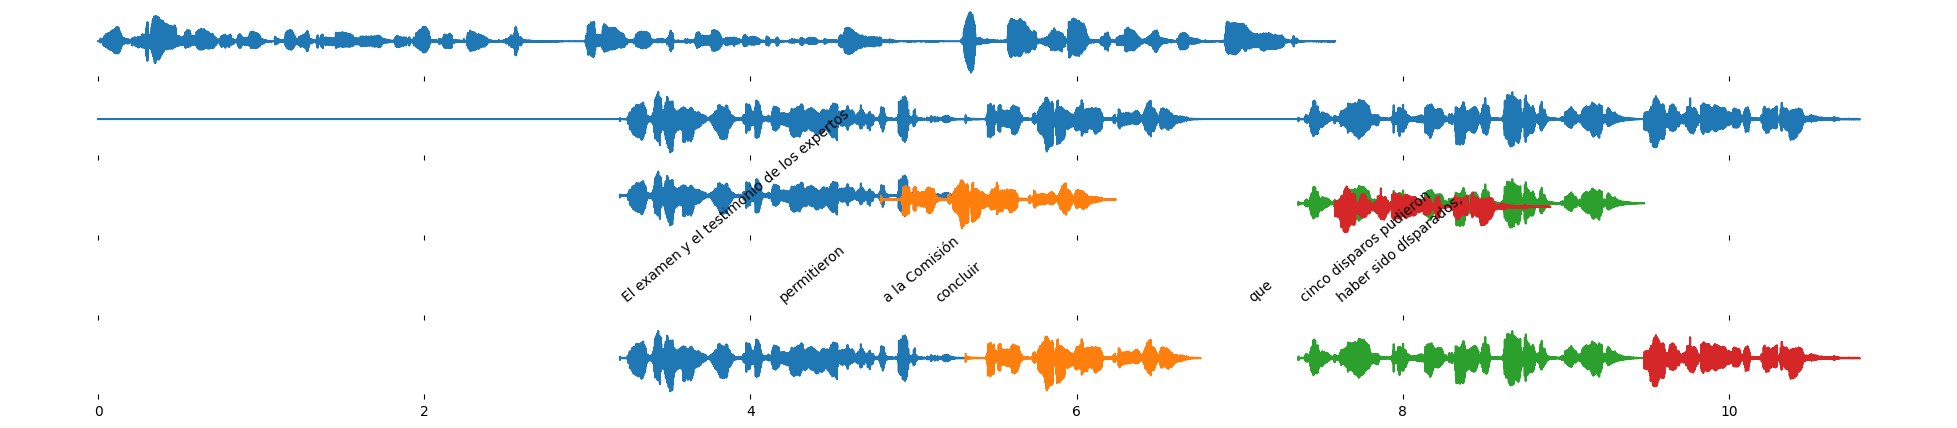

In [ ]:
target_samples, intervals = get_s2st_delayed_targets(delays, target_sample_rate, prediction_lists, speech_durations)

plot_s2st("/content/LJ_eng.wav", target_samples, target_sample_rate, intervals, delays, prediction_lists)

## Streaming HF space:
Try out the streaming HuggingFace space at: https://huggingface.co/spaces/facebook/seamless-streaming

# Unity.cpp

In [ ]:
# unity.cpp
%mkdir -p ggml/build
%cd ggml/build
!cmake -DGGML_OPENBLAS=ON -DBUILD_SHARED_LIBS=On -DCMAKE_BUILD_TYPE=Release -DCMAKE_CXX_FLAGS="-g2 -fno-omit-frame-pointer" ..
!make -j4 unity
# Download seamless_M4T_medium model, converted to ggml format
# Conversion script: https://github.com/facebookresearch/seamless_communication/blob/main/ggml/ggml_convert.py
!wget https://dl.fbaipublicfiles.com/seamless/models/seamlessM4T_medium.ggml


In [ ]:
#Launching the console. But google colab doesn't support a console in C program
./bin/unity --model seamlessM4T_medium.ggml -t 8